# Installing and Importing Dependencies

In [ ]:
# !pip install transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

# Setting Variables

In [2]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=5
MAX_LEN=512
BATCH_SIZE=16

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Reading and Preprocessing Data

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['msg', 'spam']]
# df.head()

In [3]:
!pip install -U --no-cache-dir gdown --pre
!gdown 1jCFc3dWPflO7HvVcvGoCQWnVrammEQOd
!unzip "/content/spam-dataset.zip"

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1jCFc3dWPflO7HvVcvGoCQWnVrammEQOd
To: /content/spam-dataset.zip
100% 1.05M/1.05M [00:00<00:00, 8.89MB/s]
Archive:  /content/spam-dataset.zip
   creating: spam-dataset/
  inflating: __MACOSX/._spam-dataset  
  inflating: spam-dataset/test.csv   
  inflating: __MACOSX/spam-dataset/._test.csv  
  inflating: spam-dataset/train.csv  
  inflating: __MACOSX/spam-dataset/._train.csv  


In [4]:
df_train = pd.read_csv('/content/spam-dataset/train.csv',header=None)
df_train.columns = ['msg', 'spam']
df_test = pd.read_csv('/content/spam-dataset/test.csv',header=None)
df_test.columns = ['msg', 'spam']
df_train

,msg,spam
0,Subject: enron / hpl actuals for january 24 ` ...,0
1,Subject: meet some lonely fun girls that want ...,1
2,Subject: revised nomination - june ` 2000 dare...,0
3,Subject: whats up . b u y all of your meds her...,1
4,Subject: new computer hey ! just checking out ...,0
...,...,...
3874,Subject: re : texas logistics info . daren ` h...,0
3875,Subject: re : 1601 yes ` that sounds great ! !...,0
3876,Subject: re : tenaska iv transport 10 / 00 tha...,0
3877,Subject: neon lesson # 6 please respond to - e...,0


In [5]:
df_train['msg'] = df_train['msg'].apply(lambda x: x.lower())
df_test['msg'] = df_test['msg'].apply(lambda x: x.lower())
df_train

,msg,spam
0,subject: enron / hpl actuals for january 24 ` ...,0
1,subject: meet some lonely fun girls that want ...,1
2,subject: revised nomination - june ` 2000 dare...,0
3,subject: whats up . b u y all of your meds her...,1
4,subject: new computer hey ! just checking out ...,0
...,...,...
3874,subject: re : texas logistics info . daren ` h...,0
3875,subject: re : 1601 yes ` that sounds great ! !...,0
3876,subject: re : tenaska iv transport 10 / 00 tha...,0
3877,subject: neon lesson # 6 please respond to - e...,0


In [6]:
df = pd.concat([df_test, df_train], ignore_index=True)

In [7]:
df.shape

(5172, 2)

In [8]:
class SMSCollectionDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

In [9]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SMSCollectionDataset(
        spam=df['spam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [10]:
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

((4137, 2), (518, 2), (517, 2))

In [11]:
df_train

,msg,spam
3164,subject: re : atmic hurta # 1 - new production...,0
2067,subject: the smart way to control spam i have ...,1
4717,subject: enron / hpl actuals for sept . 28 ` 2...,0
2505,subject: surely you must want some g . e . n ...,1
2268,subject: kleberg plant outages in september - ...,0
...,...,...
4426,subject: natural gas nomination for 11 / 00 en...,0
466,subject: wow look at all these adult dvds movi...,1
3092,subject: use the links to get more information...,1
3772,subject: final cp name change and merger repor...,0


In [12]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
d = next(iter(train_data_loader))
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'spam'])

In [14]:
d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

# Model Building

In [15]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [16]:
model = SpamClassifier(n_classes=2)
model = model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

# Loss, Optimizer and Scheduler

In [17]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# input_ids = d['input_ids'].to(device)
# attention_mask = d['attention_mask'].to(device)
# targets = d['spam'].to(device)

# outputs = model(
#     input_ids=input_ids,
#     attention_mask=attention_mask
# )
# loss = loss_fn(outputs, targets)
# loss

# Train Model Function

In [18]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train() # Setting Model in training mode

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device) # [16, 512]
        attention_mask = d['attention_mask'].to(device) # [16, 512]
        targets = d['spam'].to(device) # [16]

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

# Validating Model Function

In [19]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    model = model.eval() # Setting Model in evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device) # [16, 512]
            attention_mask = d['attention_mask'].to(device) # [16, 512]
            targets = d['spam'].to(device) # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

# Training the Model

In [20]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,

        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.15040190445581042 accuracy 0.9494802997341069
Validation loss 0.09842675405723805 accuracy 0.9709864603481625

Epoch 2/5
----------
Train loss 0.03347031444859058 accuracy 0.9932318104906938
Validation loss 0.04917420875316373 accuracy 0.9864603481624759

Epoch 3/5
----------
Train loss 0.01290692004739688 accuracy 0.9970993473531545
Validation loss 0.019926959269937608 accuracy 0.9961315280464217

Epoch 4/5
----------
Train loss 0.006704591936325073 accuracy 0.9990331157843848
Validation loss 0.03462625023971531 accuracy 0.9922630560928434

Epoch 5/5
----------
Train loss 0.0015592412317936258 accuracy 0.9997582789460963
Validation loss 0.0445752401949104 accuracy 0.9922630560928434

CPU times: user 20min 39s, sys: 10min 15s, total: 30min 54s
Wall time: 31min 25s


# Evaluating the Model Performance

In [21]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.9864864864864865

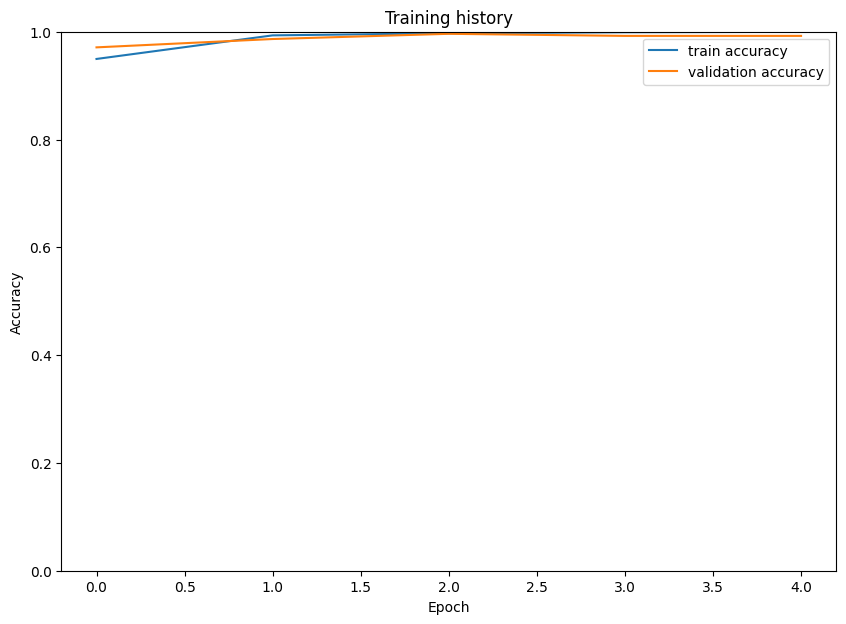

In [25]:
train_acc_np = np.array([item.cpu().item() for item in history['train_acc']])
val_acc_np = np.array([item.cpu().item() for item in history['val_acc']])

plt.figure(figsize=(10, 7))
plt.plot(train_acc_np, label='train accuracy')
plt.plot(val_acc_np, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [26]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            spam = d['spam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(spam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [27]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [28]:
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

--------Classification Report---------

                  score
accuracy       0.986486
f1-score       0.978462
precision      0.981481
recall         0.975460
roc auc score  0.983505

--------Plotting Confusion Matrix---------


,score
accuracy,0.986486
f1-score,0.978462
precision,0.981481
recall,0.975460
roc auc score,0.983505


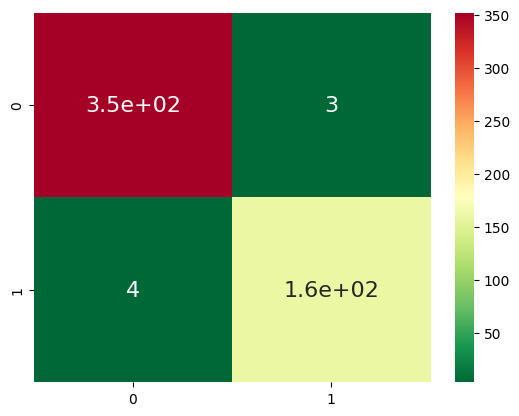

In [29]:
create_classification_report(y_test, y_pred)